# Q Learning
Reference: https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict
from forest import ForestEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
num_states = 16
env = ForestEnv(num_states=num_states)

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=0.9, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            # Consistent with https://github.com/sawcordwell/pymdptoolbox/blob/master/src/mdptoolbox/mdp.py#L1062
            if done or t >= 100:
                break
                
            state = next_state
    
    return Q, stats

In [5]:
start_time = time.time()
Q, stats = q_learning(env, 1000)
end_time = time.time()
print('Time elapsed: {} seconds'.format(end_time - start_time))

Episode 1000/1000.Time elapsed: 6.064474105834961 seconds


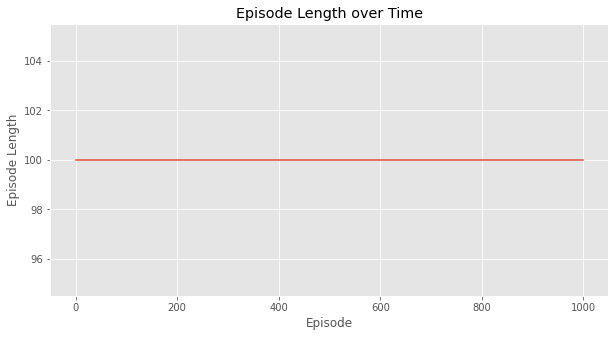

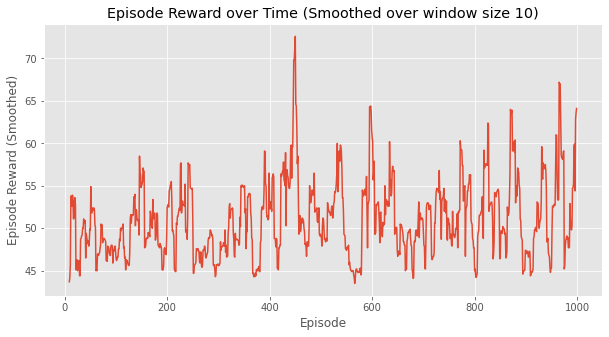

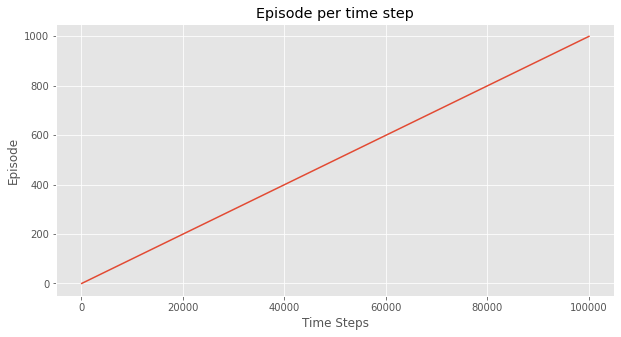

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)

In [7]:
def reconstruct_q_values(Q):
    q_values = np.zeros((num_states, 2))
    for k, v in Q.items():
        q_values[k] = v
    return q_values

q_values = reconstruct_q_values(Q)

print("Q (state-action) values:")
print(q_values)

print("Policy (for each state):")
print(np.argmax(q_values, axis=1))

print("Value Function:")
print(np.max(q_values, axis=1))

Q (state-action) values:
[[ 4.62121876  4.11780155]
 [ 4.60341661  5.15134578]
 [ 4.49546764  5.13211799]
 [ 4.39728932  5.09834162]
 [ 4.13625604  5.08145006]
 [ 4.41439222  5.17469978]
 [ 4.38124445  5.08497579]
 [ 4.76003395  5.19146756]
 [ 5.25831918  5.19258254]
 [ 6.12757981  5.09463193]
 [ 7.20032892  4.43215943]
 [ 8.68266553  5.16846856]
 [12.42584771  5.14010794]
 [16.69727162  5.12495934]
 [24.72753225  5.13830266]
 [21.53492947  6.12175794]]
Policy (for each state):
[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Value Function:
[ 4.62121876  5.15134578  5.13211799  5.09834162  5.08145006  5.17469978
  5.08497579  5.19146756  5.25831918  6.12757981  7.20032892  8.68266553
 12.42584771 16.69727162 24.72753225 21.53492947]
